# Лабораторная работа №1. Фильмы

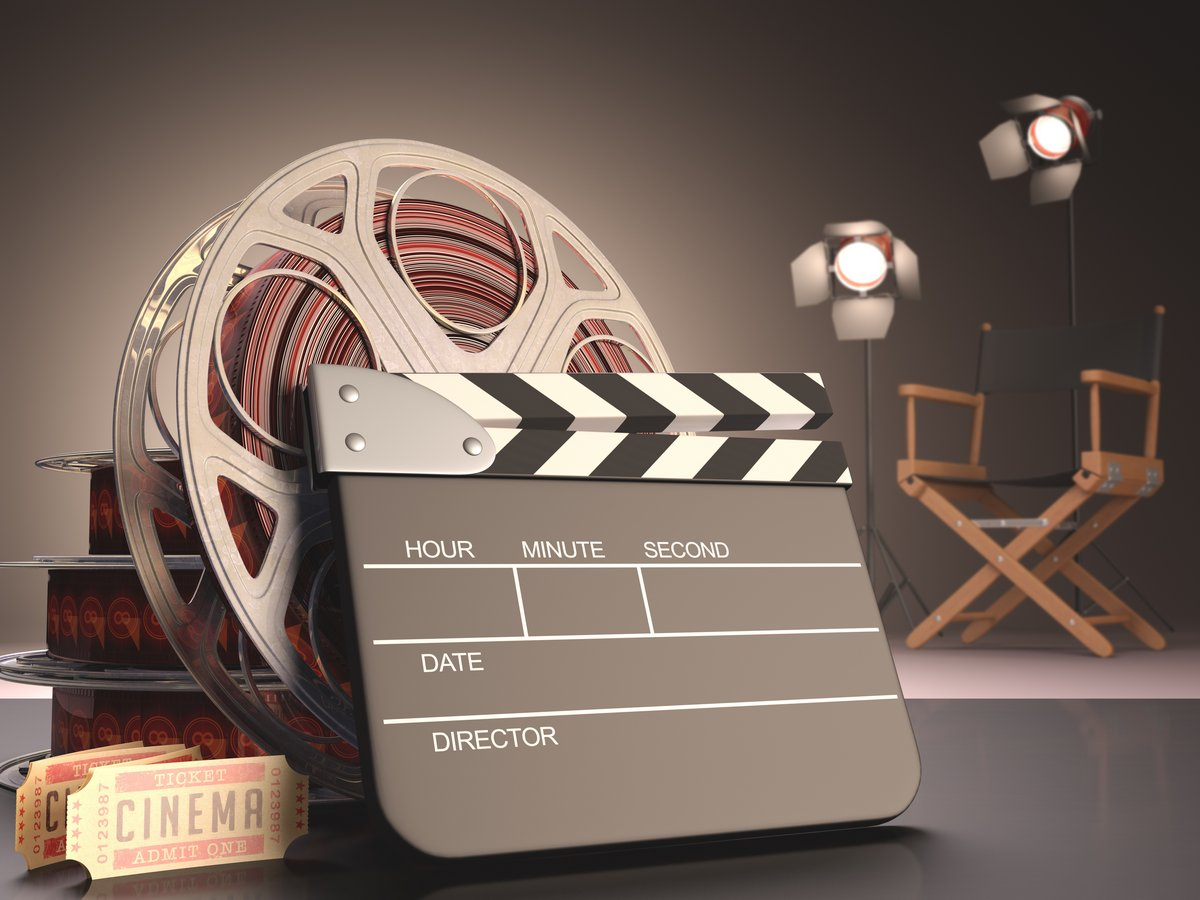

## Подготовка данных к работе

Подключаем все необходимые для работы библиотеки:

In [24]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

и открываем наш датасет и прочие полезные ссылочки, которые в дальнейшем пригодятся.

In [25]:
url = 'https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/'
r= requests.get(url)
data=r.text
soup=BeautifulSoup(data, 'html.parser')
movies_table = pd.read_csv('Dataset1.csv')

Проверим, что все открылось и работает. Выведем первые 10 строк датасета следующей командой, а также посмотрим информацию о нашем датасете:

In [26]:
movies_table.head (10)
movies_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   color                       5025 non-null   object 
 1   Director_Name               4872 non-null   object 
 2   num_Critic_for_reviews      4927 non-null   float64
 3   duration                    4959 non-null   float64
 4   director_Facebook_likes     4872 non-null   float64
 5   actor_3_Facebook_likes      4953 non-null   float64
 6   actor_2_name                4963 non-null   object 
 7   Actor_1_Facebook_likes      4968 non-null   float64
 8   gross                       4104 non-null   float64
 9   genres                      4974 non-null   object 
 10  actor_1_name                4968 non-null   object 
 11  movie_Title                 4974 non-null   object 
 12  num_voted_users             4974 non-null   float64
 13   cast_total_facebook_likes  4974 

Все открыто и работает, но как мы видим, заголовки написаны по-разному: где-то заголовок начинается с закглавной буквы, а где-то и вовсе пробел перед названием. Надо исправлять.
Выписываем список колонок, которые надо переименовать и названием, которое у них должно быть

In [27]:
movies_table = movies_table.rename (
    columns = {
        'Director_Name' : 'director_name',
        'num_Critic_for_reviews' : 'num_critic_for_reviews',
        'director_Facebook_likes': 'director_facebook_likes',
        'actor_3_Facebook_likes' : 'actor_3_facebook_likes',
        'Actor_1_Facebook_likes' : 'actor_1_facebook_likes',
        'movie_Title' : 'movie_title',
        ' cast_total_facebook_likes' : 'cast_total_facebook_likes',
        'movie_facebook_likes;' : 'movie_facebook_likes'
    }
)

Из раздела info мы видим, что не все данные имеются. Заменим их на 'unknown'. Но так как в дальнейшем для проверки гипотез хотелось бы использовать годы выхода фильмов, то нужно будет удалять отсутствующие значения(я знаю, что это влияет на статистику) 

In [28]:
columns_to_replace =['title_year']

for row in columns_to_replace:
   movies_table[row] = movies_table[row].fillna('unknown')

(movies_table.isna().sum())
movies_table = movies_table.loc[movies_table['title_year'] != 'unknown']

Уже в процессе проверки одной из гипотез (про цвет) мной было замечено, что названия, обощначающие цвет тоже отличаются наличием заглавных букв, правильностью написания и наличием пробелов. Поэтому будем приводить это все в божеский вид. Для этого создадим функции, каждая их которых отвечает за изменение названия.

In [29]:
def replace_wrong_colour (wrong_colours, correct_colour):
    for wrong_colour in wrong_colours:
        movies_table['color'] = movies_table['color'].replace(wrong_colours, correct_colour)
wrong_colours= ['Color', 'Colour', 'color']
correct_colour = 'colour'
replace_wrong_colour(wrong_colours, correct_colour)

wrong_colours= [' Black and White']
correct_colour = 'black and white'
replace_wrong_colour(wrong_colours, correct_colour)

def replace_wrong_country (wrong_country, correct_country):
    for country in wrong_country:
        movies_table['country']=movies_table['country'].replace(wrong_country, correct_country)

wrong_country=[ 'usa']
correct_country=['USA']
replace_wrong_country(wrong_country, correct_country)

А чтобы не потерять изменения, сохраним их в папке с работой:

In [30]:
movies_table.to_csv(r'2nd.csv', index= True)

Еще раз обновим команду с выводом информации, чтобы убедиться, что все работает, как надо, и что строки юез дат успешно удалены.

In [31]:
movies_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4869 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      4854 non-null   object 
 1   director_name              4869 non-null   object 
 2   num_critic_for_reviews     4829 non-null   float64
 3   duration                   4857 non-null   float64
 4   director_facebook_likes    4869 non-null   float64
 5   actor_3_facebook_likes     4852 non-null   float64
 6   actor_2_name               4860 non-null   object 
 7   actor_1_facebook_likes     4863 non-null   float64
 8   gross                      4101 non-null   float64
 9   genres                     4869 non-null   object 
 10  actor_1_name               4863 non-null   object 
 11  movie_title                4869 non-null   object 
 12  num_voted_users            4869 non-null   float64
 13  cast_total_facebook_likes  4869 non-null   float64
 1

Самое время преобразовывать цены... Логично, что в течение длительного времени инфляция порой очень сильно искажает цены. и не получается воспринимать их в действительном эквиваленте. Для этого все имеющиеся данные о бюджете и прибыли каждого фильма мы будет переводить на период 2016 года. Для этого используем сайт https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/, где указаны проценты изменения цен, начиная с 1913 года.

In [32]:
table = soup.find('table')
rows= table.tbody.findAll('tr');

years=[]
cpis=[]

for row in rows:
    year= row.findAll('td')[0].get_text()
    if year.isdigit() and int(year) < 2017:
        years.append(int(year))
        cpis.append(float(row.findAll('td')[13].get_text()))

cpi_table = pd.DataFrame({
    "year": years,
    "avg_annual_cpi": cpis
})

Создадим функцию, которая переводит все денежные суммы в эквивалент 2016 года.

In [33]:
def get_real_value(nominal_amt, old_cpi, new_cpi):                  
    real_value= (float(nominal_amt) * float(new_cpi))/old_cpi
    return real_value

CPI_2016 = float( cpi_table [ cpi_table ['year'] == 2016 ] [ 'avg_annual_cpi' ])
movies_table_year = movies_table.groupby ('title_year')['budget'].count()
(movies_table_year)

real_domestic_gross=[]
real_budget_values=[]

for index, row in movies_table.iterrows():
    gross= row['gross']
    budget= row['budget']
    year= row['title_year']
    cpi= float(cpi_table[cpi_table['year'] == int(year)]['avg_annual_cpi'])

    real_gross= get_real_value(gross, cpi, CPI_2016)
    real_budget = get_real_value(budget, cpi, CPI_2016)
    real_domestic_gross.append(real_gross)
    real_budget_values.append(real_budget)

C:\Users\NoteBook\AppData\Local\Temp\ipykernel_12240\3687019605.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  CPI_2016 = float( cpi_table [ cpi_table ['year'] == 2016 ] [ 'avg_annual_cpi' ])
C:\Users\NoteBook\AppData\Local\Temp\ipykernel_12240\3687019605.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cpi= float(cpi_table[cpi_table['year'] == int(year)]['avg_annual_cpi'])


Также переименуем некоторые столбцы, для лучшей навигации по датасету.

In [34]:
movies_table = movies_table.rename (
    columns = {
        'gross': 'real_domestic_gross',
        'budget' : 'real_domestic_budget'
    }
)

movies_table['real_domestic_gross']= real_domestic_gross
movies_table['real_budget']= real_budget_values


Можно также подсчитать прибыль каждого фильма. Сначала создаем новые списки "прибыль" и "окупаемость".
Используя несложные экономические формулы заполняем оба списка соответствующими значениями. В конце датасета добавим столбец, который и будет содержать данные об окупаемости фильма.

In [35]:
profits=[]
roi_vals=[]

for index, row in movies_table.iterrows():
    profit = row['real_domestic_gross'] - row['real_budget']
    budget = row ['real_budget']
    num= profit - budget
    den= budget
    roi = (num/den)*100

    profits.append(profit)
    roi_vals.append(roi)

movies_table['profit']= profits
movies_table['roi']=roi_vals

и еще раз сохранимся

In [36]:
movies_table.to_csv(r'2nd.csv', index= True)

Проверим через info(), что данные обновлены и выведем первые 10 строк датасета.

In [37]:
movies_table.info()
movies_table.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 4869 entries, 0 to 5042
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      4854 non-null   object 
 1   director_name              4869 non-null   object 
 2   num_critic_for_reviews     4829 non-null   float64
 3   duration                   4857 non-null   float64
 4   director_facebook_likes    4869 non-null   float64
 5   actor_3_facebook_likes     4852 non-null   float64
 6   actor_2_name               4860 non-null   object 
 7   actor_1_facebook_likes     4863 non-null   float64
 8   real_domestic_gross        4101 non-null   float64
 9   genres                     4869 non-null   object 
 10  actor_1_name               4863 non-null   object 
 11  movie_title                4869 non-null   object 
 12  num_voted_users            4869 non-null   float64
 13  cast_total_facebook_likes  4869 non-null   float64
 1

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,real_domestic_gross,genres,...,content_rating,real_domestic_budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,real_budget,profit,roi
0,colour,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,8.507937e+08,Action|Adventure|Fantasy|Sci-Fi,...,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000;,2.651368e+08,5.856569e+08,120.888543
1,colour,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,3.582208e+08,Action|Adventure|Fantasy,...,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0;,3.473329e+08,1.088790e+07,-96.865283
2,colour,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,2.025981e+08,Action|Adventure|Thriller,...,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000;,2.480907e+08,-4.549257e+07,-118.337071
3,colour,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,4.684551e+08,Action|Thriller,...,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000;,2.613385e+08,2.071167e+08,-20.747743
5,colour,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,7.637218e+07,Action|Adventure|Sci-Fi,...,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000;,2.756598e+08,-1.992877e+08,-172.294775
6,colour,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,3.896268e+08,Action|Adventure|Romance,...,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0;,2.987063e+08,9.092051e+07,-69.561898
7,colour,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,2.210219e+08,Adventure|Animation|Comedy|Family|Fantasy|Musi...,...,PG,260000000.0,2010.0,553.0,7.8,1.85,29000;,2.861734e+08,-6.515148e+07,-122.766438
8,colour,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,4.647818e+08,Action|Adventure|Sci-Fi,...,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000;,2.531538e+08,2.116281e+08,-16.403360
9,colour,David Yates,375.0,153.0,282.0,10000.0,Daniel Radcliffe,25000.0,3.378055e+08,Adventure|Family|Fantasy|Mystery,...,PG,250000000.0,2009.0,11000.0,7.5,2.35,10000;,2.796802e+08,5.812535e+07,-79.217208
10,colour,Zack Snyder,673.0,183.0,0.0,2000.0,Lauren Cohan,15000.0,3.302491e+08,Action|Adventure|Sci-Fi,...,PG-13,250000000.0,2016.0,4000.0,6.9,2.35,197000;,2.500000e+08,8.024906e+07,-67.900375


## Постановка гипотез и их проверка

одним из заинтересовавших меня столбцов был "количество лиц на постере". Помню помню оооочень большой постер в одному из фильму про Мстителей, но количество лиц на нем мне не известно. Поэтому интереса ради готова сформулировать первую гипотезу(все остальные также основаны на том, что мне интересно)

Гипотеза 1. Существует фильм, на постере к которому изображено более 50 лиц
Гипотеза 2. Черно-белые фильмы снимались до 1960х годов
Гипотеза 3. Самый неокупаемый фильм был снят в США

Теперь, когда цели известны и задачи поставлены, можно приступать к реализации!

### Гипотеза 1. Существует фильм, на постере к которому изображено более 50 лиц

Для проверки данной гипотезы нужно отсортировать список фильмов по убыванию критери "кол-во лиц на постере"

In [38]:
poster=movies_table.groupby ('facenumber_in_poster')['facenumber_in_poster'].count()
the_biggest_poster=poster.sort_values(ascending=True)
print(the_biggest_poster)

facenumber_in_poster
43.0       1
19.0       1
14.0       1
31.0       1
13.0       2
12.0       4
11.0       5
15.0       6
10.0      10
9.0       17
8.0       34
7.0       47
6.0       74
5.0      104
4.0      198
3.0      366
2.0      693
1.0     1213
0.0     2079
Name: facenumber_in_poster, dtype: int64


Получается, что максимальное число лиц на постере- это 43. До гипотезы не дотягивает, конечно, но надо узнать, что это за фильм такой(500 дней лета)

In [39]:
super_film=movies_table.loc[movies_table['facenumber_in_poster']==43]
super_film

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,real_domestic_gross,genres,...,content_rating,real_domestic_budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,real_budget,profit,roi
3468,colour,Marc Webb,331.0,95.0,464.0,11000.0,Chloë Grace Moretz,23000.0,3.623690e+07,Comedy|Drama|Romance,...,PG-13,7500000.0,2009.0,17000.0,7.7,2.35,40000;,8.390406e+06,2.784650e+07,231.884987


ВЫВОД:
Таким образом, первая гипотеза оказалась неподтвержденной, а значит, среди указанных в таблице фильмов нет такого, постер к которому содержал бы более 50 лиц.

### Гипотеза 2. Первый цветной фильм появился в 1930х годах

Появление цветного фотоаппарата и телефизора кардинально изменили киноиндустрию. А в каком году это произошло? Не залезая в Интернет, давайте узнаем, когда был снят первый(или может быть, крайний) цветной фильм.
Для этого сгруппируем все фильмы по двум признакам: год выпуска и цветовая характеристика.

In [40]:
colourful_df=movies_table.loc[movies_table.loc[:,'color']=='colour']

colourful1=colourful_df.loc[colourful_df['title_year']<1940]
number=colourful1['title_year'].count()
print(number)
colourful1

2


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,real_domestic_gross,genres,...,content_rating,real_domestic_budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,real_budget,profit,roi
3970,colour,Victor Fleming,157.0,226.0,149.0,248.0,George Reeves,503.0,3.430119e+09,Drama|History|Romance|War,...,G,3977000.0,1939.0,384.0,8.2,1.37,16000;,6.866963e+07,3.361450e+09,4795.103797
4449,colour,William Cottrell,145.0,83.0,0.0,31.0,Billy Gilbert,82.0,3.082181e+09,Animation|Family|Fantasy|Musical,...,Approved,2000000.0,1937.0,47.0,7.7,1.37,0;,3.333431e+07,3.048847e+09,9046.274250


Как мы видим из таблицы, есть всего 2 цветных фильма, выпущенных до 1940 года.

Выводы:
Мы нашли два цветных фильма, которые были выпущены до 1940 года. Таким образом, гипотеза подтверждена.

### Гипотеза 3. Самый неокупаемый фильм был снят не в США

Используя величину ROI, которая показывает окупаемость фильма, можно узнать, какие из них "провалились" в прокате, а какие, наоборот, преуспели.
Чтобы подтвердить или опровергнуть данную гипотезу, создадим датасет, содержащий фильмы с минимальной окупаемостью, а затем просто взглянем на страну фильма с минимальной ROI

In [41]:
roi_df=movies_table.loc[movies_table['roi']<-199.99].sort_values(by=['roi'])
roi_df.head(1)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,real_domestic_gross,genres,...,content_rating,real_domestic_budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,real_budget,profit,roi
3330,colour,Ekachai Uekrongtham,66.0,96.0,3.0,305.0,Mike Dopud,2000.0,164.238367,Action|Crime|Thriller,...,R,9000000.0,2014.0,368.0,5.7,2.35,0;,9.124354e+06,-9.124189e+06,-199.9982


Как видно из таблицы, самый неокупившийся фильм был снят режиссером Ekachai Uekrongtham в 2014 году. Его окупаемость составила -199.998200%, а страна, в которой был снят этот фильм- Таиланд.

Выводы:
проведя анализ датасета можно сделать вывод, что гипотеза была подтверждена.

In [42]:
table=movies_table.pivot_table(index=['color'], columns=['title_year'], values= ['movie_title'], aggfunc='count')
table

movie_title                                                   \
title_year           1916.0 1920.0 1925.0 1927.0 1929.0 1930.0 1932.0 1933.0   
color                                                                          
black and white         1.0    1.0    1.0    1.0    2.0    1.0    1.0    2.0   
colour                  NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                               ...                                            \
title_year      1934.0 1935.0  ... 2007.0 2008.0 2009.0 2010.0 2011.0 2012.0   
color                          ...                                             
black and white    1.0    1.0  ...    4.0    2.0    5.0    NaN    2.0    5.0   
colour             NaN    NaN  ...  197.0  215.0  249.0  227.0  217.0  212.0   

                                             
title_year      2013.0 2014.0 2015.0 2016.0  
color                                        
black and white    5.0    3.0    1.0    NaN  
colour           228.0  241.0  221.0  104.0  

[2 rows x 91 columns]